In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from ddpm import *
import utils
from diffusers import UNet2DModel, DDIMScheduler

/nethome/zwang910/file_storage/miniconda3/envs/dl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cl_train_loaders, cl_test_loaders, train_loader, test_loader = utils.get_cl_dataset('mnist', batch_size=64, normalize=True, greyscale=False)

Building DataLoaders for each class in train dataset...


100%|██████████| 60000/60000 [00:06<00:00, 8836.66it/s]


Building DataLoaders for each class in MNIST test dataset...


100%|██████████| 10000/10000 [00:01<00:00, 8929.22it/s]


In [9]:
# 1. Hyperparameters for MNIST
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
lr = 2e-4
num_epochs = 100
num_timesteps = 1000
# instantiate scheduler and UNet
scheduler = NoiseScheduler(timesteps=1000, device=device)
unet = UNet2DModel(
    sample_size=32,         
    in_channels=1,
    out_channels=1,
    block_out_channels=(16,16),
    down_block_types=("DownBlock2D","DownBlock2D"),
    up_block_types=("UpBlock2D","UpBlock2D"),
    layers_per_block=1,
    norm_num_groups=8,
    num_class_embeds=2
)
ddpm = DDPM(unet=unet, scheduler=scheduler, n_classes=0, device=device)
scheduler = DDIMScheduler(num_train_timesteps=1000)

In [8]:
# compute the number of parameters in the model
num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print(f"Number of trainable parameters in the model: {num_params}")
# create a square matrix of the shape of the model
# square_matrix = torch.zeros((int(num_params), int(num_params)), device=device)

Number of trainable parameters in the model: 68753


In [44]:
# delete the square matrix from GPU
del square_matrix
# clear the cache
torch.cuda.empty_cache()

NameError: name 'square_matrix' is not defined

In [12]:
# 1. Hyperparameters for CIFAR10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
lr = 2e-4
num_epochs = 100
num_timesteps = 200
# instantiate scheduler and UNet
scheduler = NoiseScheduler(timesteps=num_timesteps, device=device)
unet = UNet2DModel(
    sample_size=32,         
    in_channels=3,
    out_channels=3,
    block_out_channels=(128, 256, 256, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types= ("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    downsample_type="resnet",
    upsample_type="resnet",
    dropout=0.1,
    layers_per_block=2,
)
ddpm = DDPM(unet=unet, scheduler=scheduler, n_classes=0, device=device)
scheduler = DDIMScheduler(num_train_timesteps=1000)

 19%|█▉        | 19/100 [01:23<05:53,  4.37s/it]

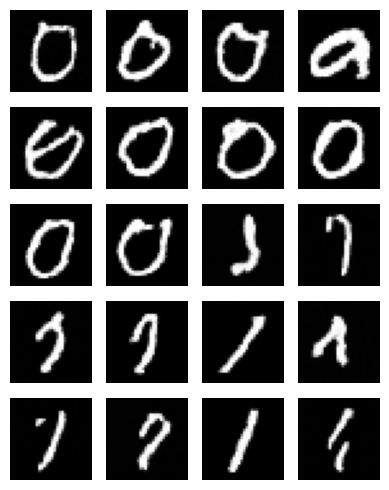

 39%|███▉      | 39/100 [02:55<04:27,  4.38s/it]

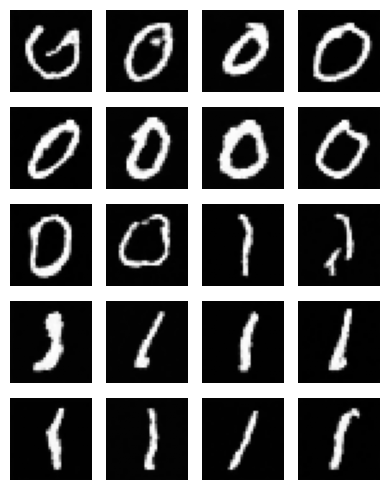

 59%|█████▉    | 59/100 [04:28<03:01,  4.42s/it]

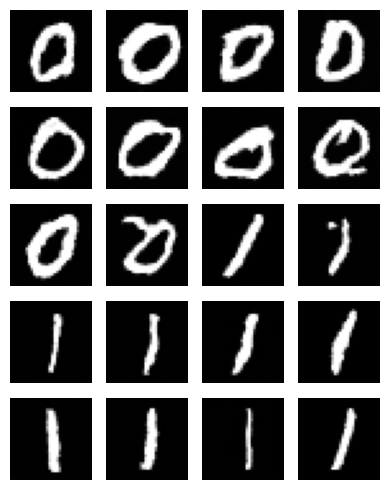

 79%|███████▉  | 79/100 [06:01<01:32,  4.42s/it]

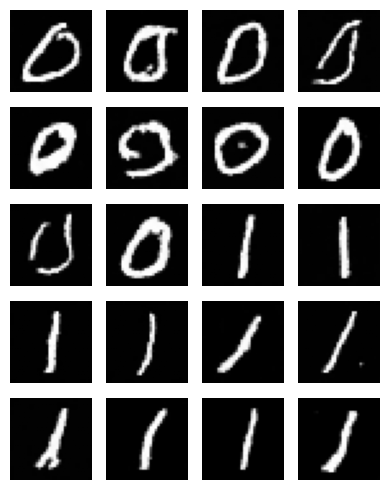

 99%|█████████▉| 99/100 [07:35<00:04,  4.42s/it]

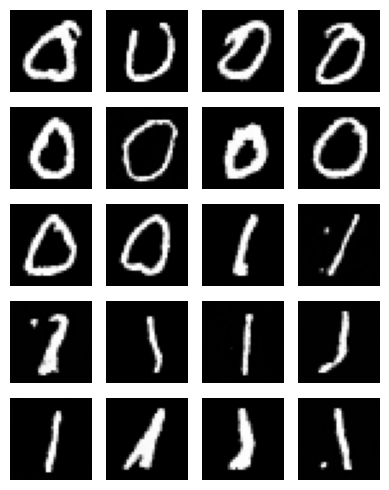

100%|██████████| 100/100 [07:44<00:00,  4.64s/it]


In [29]:
# train DDPM
optimizer = torch.optim.Adam(ddpm.parameters(), lr=lr)
ddpm.train()

for class_id, loader in cl_train_loaders.items():
    if class_id != 0:
        continue
    for epoch in tqdm(range(num_epochs)):
        # print(f"Epoch {epoch+1}/{num_epochs}")
        # pbar = tqdm(loader, desc="Training")
        for batch in loader:
            images, labels = batch
            # change image to grayscale
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            pred_noise, noise = ddpm(images, y=labels)
            loss = F.mse_loss(pred_noise, noise)

            loss.backward()
            optimizer.step()

            # pbar.set_postfix({"loss": loss.item()})

        # visualize every 50 epochs
        if (epoch + 1) % 20 == 0:
            # 5) Sampling example
            ddpm.eval()
            samples = ddpm.sample(
                num_samples_per_label=10,
                image_dim=(1, 32, 32),
                condition=torch.arange(0, 2).to(device)
            ).view(5, 4, 1, 32, 32)
            # print(samples.shape)
            # display samples in num_samples_per_label by len(condition) grid
            fig, axes = plt.subplots(5,
                            4,
                            figsize=(4, 5),
                            squeeze=False)

            for i in range(5):
                for j in range(4):
                    img = samples[i, j].cpu().permute(1, 2, 0) * 0.5 + 0.5  # (H, W, C)
                    axes[i, j].imshow(img, cmap='gray')
                    axes[i, j].axis('off')

            plt.tight_layout()
            plt.show()

    break

In [ ]:
# save model
torch.save(ddpm.state_dict(), 'ddpm_cifar10.pth')

In [6]:
# load model
ddpm.load_state_dict(torch.load('ddpm_cifar10.pth'))

<All keys matched successfully>

In [39]:
unet.load_state_dict(torch.load('model.pth'), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['class_embedding.weight'])

In [30]:
import torch.nn.functional as F
# PCA on eigenvectors
# step 1, get the scores
# unet.eval()
ddpm.unet.eval()
scores = []
param_scores = []
t_level = 400
total_cnt = 0
for class_id, loader in cl_train_loaders.items():
    if class_id != 0:
        continue
    for batch in tqdm(loader):
        images, labels = batch

        for img, label in zip(images, labels):
            # images = images.to(device)
            # labels = labels.to(device)
            img = img.unsqueeze(0)
            label = label.unsqueeze(0)
            img = img.to(device)
            label = label.to(device)
            # print(labels)
            # break

            # b = images.shape[0]
            # t = torch.randint(0, ddpm.scheduler.timesteps, (b,), device=ddpm.device).long()
            t = torch.full((1,), t_level, device=ddpm.device).long()
            noise = torch.randn_like(img, device=ddpm.device)
            noisy_x = scheduler.add_noise(img, noise, t)

            # get data score
            # with torch.no_grad():
            pred_noise = ddpm.unet(img, t, label).sample#.detach()
            score = -pred_noise
            scores.append(score.flatten(1).cpu())

            # get parameter score
            optimizer.zero_grad()
            loss = F.mse_loss(pred_noise, noise)
            loss.backward()
            param_score = torch.cat([p.grad.flatten() for p in unet.parameters() if p.requires_grad])
            # print(param_score.shape)
            param_scores.append(param_score.cpu())
            # total_cnt += b
    
    break
scores = torch.cat(scores, dim=0)  # shape: (N, 3*32*32) # shape: (N, 3072)
param_scores = torch.stack(param_scores, dim=0)  # shape: (num_params,)
print(scores.shape, param_scores.shape)

100%|██████████| 198/198 [03:23<00:00,  1.03s/it]


torch.Size([12665, 784]) torch.Size([12665, 68881])


In [31]:
param_scores.to('cuda')

tensor([[-0.0007, -0.0154, -0.0076,  ..., -0.3814, -0.4076, -0.5351],
        [-0.0065, -0.0276, -0.0083,  ..., -0.3513, -0.4005, -0.5437],
        [-0.0108, -0.0427, -0.0398,  ..., -0.2696, -0.3234, -0.5448],
        ...,
        [-0.0174, -0.0377, -0.0316,  ..., -0.2127, -0.2322, -0.4223],
        [-0.0070, -0.0175, -0.0073,  ..., -0.2483, -0.2243, -0.4123],
        [ 0.0039, -0.0081,  0.0043,  ..., -0.4007, -0.3886, -0.5302]],
       device='cuda:0')

In [32]:
# center
# scores = scores - scores.mean(dim=0, keepdim=True)
# empirical Fisher
Fisher = (param_scores.t() @ param_scores) / param_scores.shape[0]                 # (D, D)
Fisher.shape

torch.Size([68881, 68881])

In [62]:
def check_sym_posdef(A):
    print("dtype:", A.dtype, "shape:", A.shape)
    print("contains NaN? ", torch.isnan(A).any().item())
    print("contains Inf? ", torch.isinf(A).any().item())
    print("max |A - Aᵀ|:", (A - A.T).abs().max().item())

check_sym_posdef(Fisher)

# Fixes
# A = torch.nan_to_num(Fisher)            # remove NaN/Inf
# A = 0.5 * (A + A.T)                # force symmetry
# A = A.contiguous()                 # avoid stride issues

dtype: torch.float32 shape: torch.Size([68753, 68753])
contains NaN?  False
contains Inf?  False


OutOfMemoryError: CUDA out of memory. Tried to allocate 17.61 GiB. GPU 0 has a total capacity of 44.45 GiB of which 2.37 GiB is free. Including non-PyTorch memory, this process has 42.07 GiB memory in use. Of the allocated memory 35.48 GiB is allocated by PyTorch, and 6.24 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [37]:
# ensure on GPU if you want acceleration
Fisher = Fisher.to('cuda')
torch.backends.cuda.preferred_linalg_library("magma")
# eigvals, eigvecs = torch.linalg.eigh(A)

# symmetric eigendecomposition
eigs, vecs = torch.linalg.eigh(Fisher)
print(eigs)
# sort descending
eigs, indices = eigs.sort(descending=True)
vecs = vecs[:, indices]                      # columns are eigenvectors

tensor([-6.0237e-06, -2.0223e-06, -1.8569e-06, -1.4500e-06, -1.2121e-06,
        -1.1897e-06, -1.0514e-06, -9.7609e-07, -8.8254e-07, -8.7354e-07,
        -8.4185e-07, -7.8574e-07, -7.7834e-07, -7.3878e-07, -7.3704e-07,
        -7.3198e-07, -6.9350e-07, -6.7201e-07, -6.5633e-07, -6.2043e-07,
        -6.1442e-07, -5.9640e-07, -5.6248e-07, -5.4057e-07, -5.3612e-07,
        -4.8413e-07, -4.8382e-07, -4.5057e-07, -4.4324e-07, -4.3560e-07,
        -4.3241e-07, -3.9197e-07, -3.8913e-07, -3.6475e-07, -3.6457e-07,
        -3.5054e-07, -3.4264e-07, -3.0205e-07, -2.8071e-07, -2.8066e-07,
        -2.7344e-07, -2.5175e-07, -2.3367e-07, -2.2426e-07, -2.2067e-07,
        -2.1614e-07, -2.0684e-07, -1.9616e-07, -1.7529e-07, -1.6684e-07,
        -1.5988e-07, -1.2055e-07, -1.0888e-07, -9.4516e-08, -9.1685e-08,
        -7.9514e-08, -7.1008e-08, -5.7376e-08, -3.8476e-08, -1.9958e-08,
        -1.9537e-08, -5.7632e-09,  1.6800e-08,  2.6566e-08,  3.6651e-08,
         4.2200e-08,  6.4085e-08,  7.2367e-08,  9.0

In [38]:
eigs[0] / eigs.sum()

tensor(0.5049, device='cuda:0', grad_fn=<DivBackward0>)

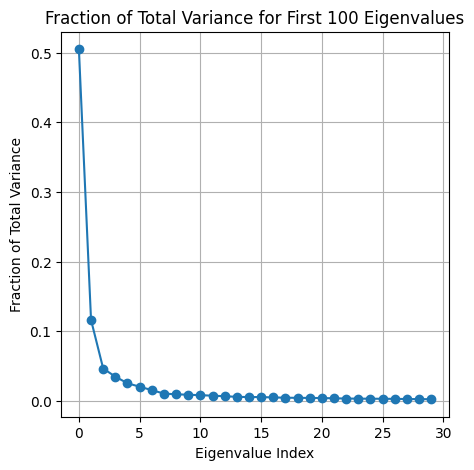

In [39]:
# pleaae scatter plot the fraction for the first 100 eigenvalues
plt.figure(figsize=(5, 5))
plt.plot(eigs[:30].detach().cpu().numpy() / eigs.sum().detach().cpu().numpy(), marker='o')
plt.xlabel("Eigenvalue Index")
plt.ylabel("Fraction of Total Variance")
plt.title("Fraction of Total Variance for First 100 Eigenvalues")
plt.grid()
plt.show()

In [40]:
# compute effective rank
effective_rank = eigs.sum() ** 2 / (eigs ** 2).sum()
print(f"Effective Rank: {effective_rank.item()}")

Effective Rank: 3.648374557495117


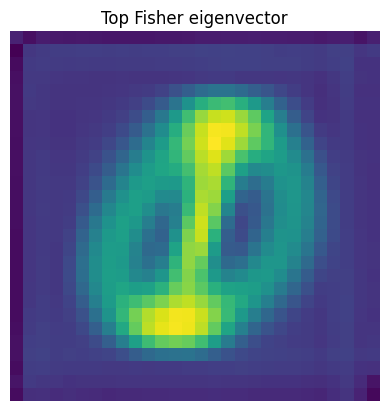

In [39]:
u1 = vecs[:, 0]                  # (3072,)
u1_img = u1.view(1, 28, 28)      # (C,H,W)
u1_img = u1_img.permute(1,2,0) * 0.5 + 0.5  # (H,W,C) and normalize to [0,1]
import matplotlib.pyplot as plt
plt.imshow(u1_img.cpu().numpy())
plt.axis('off')
plt.title("Top Fisher eigenvector")
plt.show()

In [40]:
scores.to('cuda')

tensor([[0.4517, 0.4763, 0.4515,  ..., 0.3895, 0.4210, 0.5120],
        [0.4388, 0.4905, 0.4644,  ..., 0.3924, 0.4375, 0.4423],
        [0.4264, 0.4868, 0.4669,  ..., 0.4243, 0.4676, 0.4890],
        ...,
        [0.4300, 0.4839, 0.4634,  ..., 0.4214, 0.4610, 0.4803],
        [0.4461, 0.4806, 0.4602,  ..., 0.4140, 0.4554, 0.4980],
        [0.4559, 0.4684, 0.4440,  ..., 0.3887, 0.4164, 0.5152]],
       device='cuda:0')

In [3]:
# a random tensor fo shape (5000, 768)
random_tensor = torch.randn(100, 60000).to('cuda')
Fisher = random_tensor.t() @ random_tensor / random_tensor.shape[0]  # (768, 768)
# is Fisher symmetric? Answer: Yes
# Why? Because it is a dot product of a matrix with itself, which is always symmetric.
print(Fisher.shape)
param_scores = random_tensor

torch.Size([60000, 60000])


In [33]:
# assume Fisher is your [D×D] matrix on CPU or GPU
F = Fisher.to('cpu')  # ensure Fisher is on the same device as scores
print(F.shape, param_scores.shape)
param_scores = param_scores.to('cpu')  # ensure param_scores is on the same device as Fisher

# 2.1 Frobenius‐norm error of rank‑1
# eigvals, eigvecs = torch.linalg.eigh(F)
# λ1 = eigvals[-1]
# u1 = eigvecs[:, -1]
# F_r1 = λ1 * u1.unsqueeze(1) @ u1.unsqueeze(0)
# err_r1 = torch.linalg.norm(F - F_r1)       # Frobenius norm

# 2.2 Frobenius‐norm error of diagonal
F_diag = torch.diag(torch.diag(F))
err_diag = torch.linalg.norm(F - F_diag)

# # 2.3 rank-1 + diagonal approximation
# F_diag_r1 = F_diag + F_r1
# err_diag_r1 = torch.linalg.norm(F - F_diag_r1)

# 2.4 rank-1 as score
F_r1_score = param_scores.mean(dim=0).unsqueeze(1) @ param_scores.mean(dim=0).unsqueeze(0)
err_r1_score = torch.linalg.norm(F - F_r1_score)

print(f"‖F-F_diag‖_F = {err_diag:.3f},  ‖F-F_r1_score‖_F = {err_r1_score:.3f}")


torch.Size([68881, 68881]) torch.Size([12665, 68881])
‖F-F_diag‖_F = 17.475,  ‖F-F_r1_score‖_F = 1.491


In [12]:
total_variance = torch.trace(F)
r1_variance = torch.trace(F_r1_score)  # = ||ḡ||^2
ratio = r1_variance / total_variance   # % variance captured
print(f"Rank-1 score captures {ratio:.2%} of the total variance in Fisher matrix.")

diag_variance = torch.trace(F_diag)
diag_ratio = diag_variance / total_variance
print(f"Diagonal captures {diag_ratio:.2%} of the total variance in Fisher matrix.")

Rank-1 score captures 99.16% of the total variance in Fisher matrix.
Diagonal captures 100.00% of the total variance in Fisher matrix.


In [42]:
fnorm = torch.linalg.norm(F)            # = √(∑_i λ_i²)
print("Rel err r1: ", err_r1/fnorm)     # ~25%
print("Rel err diag:", err_diag/fnorm)  # ~100%
print("Rel err diag+r1:", err_diag_r1/fnorm)  # ~25%


Rel err r1:  tensor(0.1831)
Rel err diag: tensor(0.9980)
Rel err diag+r1: tensor(0.1832)


In [5]:
import torch

# Sample inputs
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)  # variable we will differentiate wrt
y = torch.tensor([2.0, 2.0, 2.0])                      # ground‑truth targets

# Forward pass: y_pred = x^2
y_pred = x ** 2

# Mean‑squared error loss
loss = F.mse_loss(y_pred, y)

# Backward pass: compute d(loss)/d(x)
loss.backward()

# Show results
print("y_pred:", y_pred.detach().numpy())
print("loss:", loss.item())
print("gradient dMSE/dx:", x.grad.numpy())

y_pred: [1. 4. 9.]
loss: 18.0
gradient dMSE/dx: [-1.3333334  5.3333335 28.000002 ]
